In [ ]:
!pip install catboost scikit-learn pandas gensim tensorflow keras



Feature Extraction Method: Tf-Idf

Classifier: CatBoost
Learning rate set to 0.089818
0:	learn: 2.3105147	total: 15.2ms	remaining: 15.2s
1:	learn: 2.1772722	total: 30.6ms	remaining: 15.3s
2:	learn: 2.0845815	total: 52.7ms	remaining: 17.5s
3:	learn: 2.0132919	total: 75.9ms	remaining: 18.9s
4:	learn: 1.9557271	total: 91.5ms	remaining: 18.2s
5:	learn: 1.9078787	total: 107ms	remaining: 17.8s
6:	learn: 1.8673348	total: 126ms	remaining: 17.8s
7:	learn: 1.8325076	total: 146ms	remaining: 18.1s
8:	learn: 1.8022846	total: 162ms	remaining: 17.8s
9:	learn: 1.7758497	total: 177ms	remaining: 17.6s
10:	learn: 1.7525828	total: 193ms	remaining: 17.4s
11:	learn: 1.7357015	total: 208ms	remaining: 17.1s
12:	learn: 1.7170094	total: 223ms	remaining: 16.9s
13:	learn: 1.7032737	total: 238ms	remaining: 16.7s
14:	learn: 1.6880860	total: 254ms	remaining: 16.7s
15:	learn: 1.6793222	total: 268ms	remaining: 16.5s
16:	learn: 1.6666223	total: 284ms	remaining: 16.4s
17:	learn: 1.6552067	total: 300ms	remaining: 16.4s


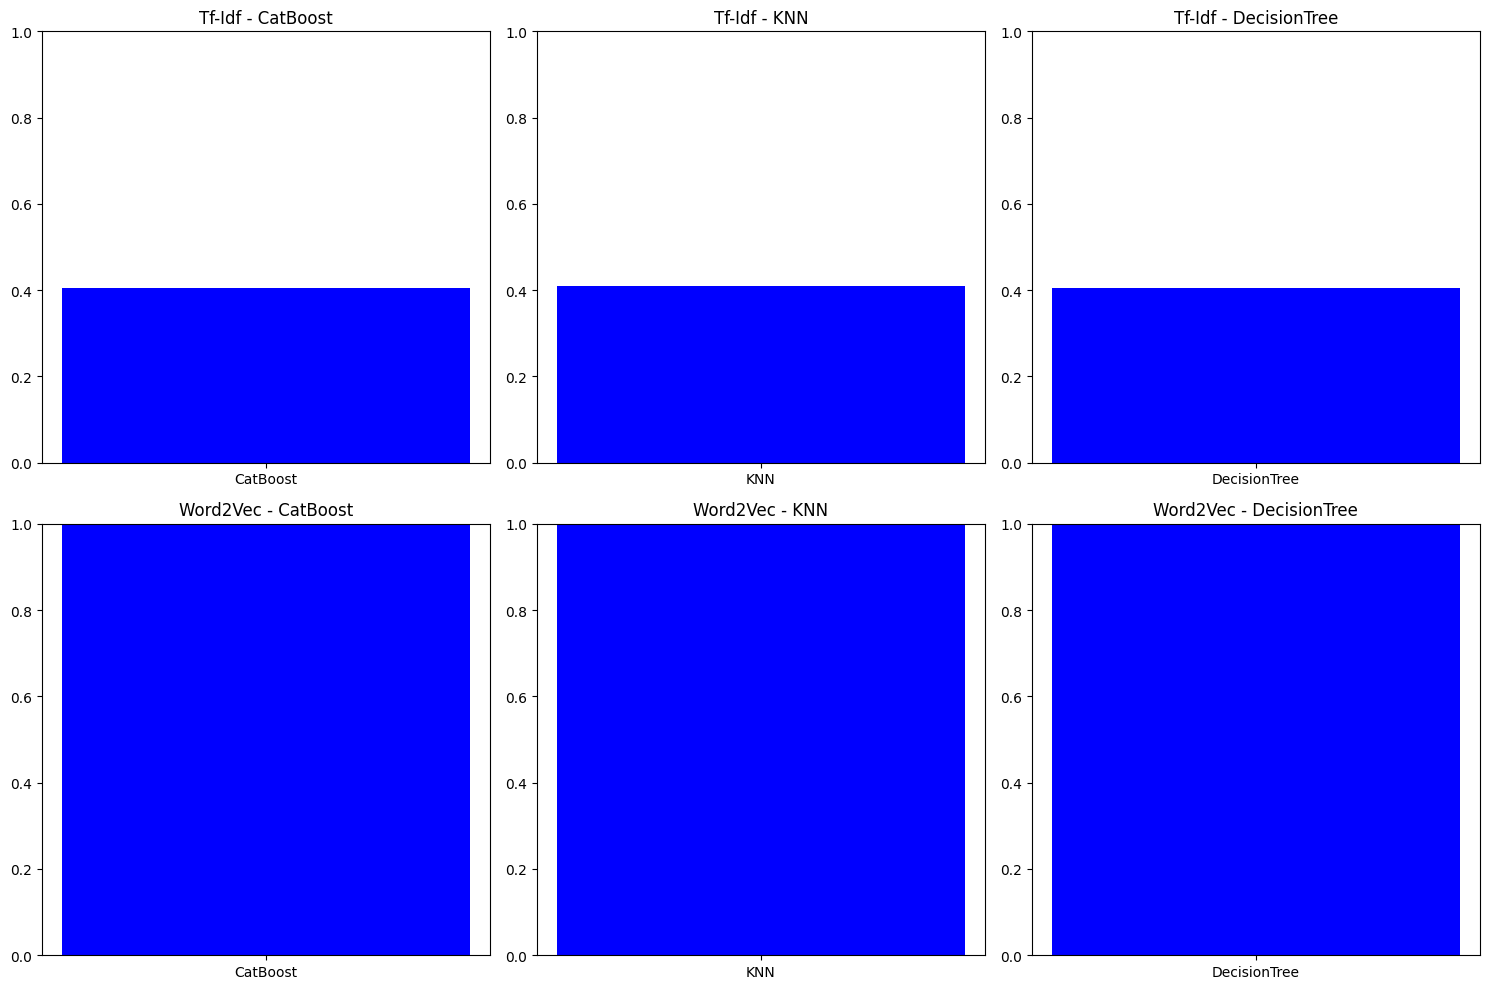

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load Chinese Digit Mnist dataset
# Replace 'path_to_chinese_digit_mnist.csv' with the actual path to your dataset
data = pd.read_csv('/content/chineseMNIST.csv')

# Convert 'text' column to strings
data['label'] = data['label'].astype(str)

# Assuming your dataset has columns 'text' for input and 'label' for output
X = data['label']
y = data['character']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize tokenizer
tokenizer = Tokenizer()

# Define functions for feature extraction
def tfidf_feature_extraction(X_train, X_test):
    tfidf_vectorizer = TfidfVectorizer(lowercase=False)  # Set lowercase to False
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf

def word2vec_feature_extraction(X_train, X_test):
    # Tokenize the sentences
    tokenizer.fit_on_texts(X_train)
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences to have consistent length
    global max_len
    max_len = max(max(len(seq) for seq in X_train_sequences), max(len(seq) for seq in X_test_sequences))
    X_train_pad = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
    X_test_pad = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')

    # Train Word2Vec model
    word2vec_model = Word2Vec(sentences=X_train_sequences, vector_size=100, window=5, min_count=1, workers=4)

    # Generate embeddings for each word in the vocabulary
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

    return X_train_pad, X_test_pad, embedding_matrix

# Define classifiers
classifiers = {
    'CatBoost': CatBoostClassifier(),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
}

# Initialize results dictionary
results = {}

# Initialize plots
fig, axes = plt.subplots(nrows=len(['Tf-Idf', 'Word2Vec']), ncols=len(classifiers), figsize=(15, 10))

# Iterate over feature extraction methods
for idx, feature_extraction_method in enumerate(['Tf-Idf', 'Word2Vec']):
    print(f"\nFeature Extraction Method: {feature_extraction_method}")

    # Extract features
    if feature_extraction_method == 'Tf-Idf':
        X_train_feature, X_test_feature = tfidf_feature_extraction(X_train, X_test)
    elif feature_extraction_method == 'Word2Vec':
        X_train_feature, X_test_feature, _ = word2vec_feature_extraction(X_train, X_test)

    # Iterate over classifiers
    for j, (classifier_name, classifier) in enumerate(classifiers.items()):
        print(f"\nClassifier: {classifier_name}")

        classifier.fit(X_train_feature, y_train)
        y_pred = classifier.predict(X_test_feature)

        # Evaluate and store results
        accuracy = accuracy_score(y_test, y_pred)
        results[f'{classifier_name}_{feature_extraction_method}'] = accuracy
        print(f"Accuracy: {accuracy}")

        # Plot results
        axes[idx, j].bar(classifier_name, accuracy, color='blue')
        axes[idx, j].set_title(f'{feature_extraction_method} - {classifier_name}')
        axes[idx, j].set_ylim([0, 1])

# Display results in a table
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
print("\nResults:")
print(results_df)

# Show plots
plt.tight_layout()
plt.show()
